# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-2000a']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.19 MiB | 27.28 MiB/s, done.
Resolving deltas: 100% (26319/26319), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # actual architecture below is scaled to match n: [0.5, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [464, shufflenet_v2_x1_0, DEFAULT, True, 2, True]] # 0

head:
  - [0, 1, Index, [116, 5]]           # 1: P3
  - [1, 1, ECA, [116]]                # 2
  - [0, 1, Index, [232, 6]]           # 3: P4
  - [3, 1, ECA, [232]]                # 4
  - [0, 1, Index, [464, 7]]           # 5: P5
  - [5, 1, ECA, [464]]                # 6

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [2, 1, Conv, [64, 1, 1]]         # 7: P3 → 64
  - [4, 1, Conv, [128, 1, 1]]        # 8: P4 → 128
  - [6, 1, Conv, [256, 1, 1]]        # 9: P5 → 256

  # FPN: P5 → P4
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 8], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [128, False]]                # 12 (2 → 1 repeat, 512 → 128)

  # FPN: P4 → P3
  - [12, 1, nn.Upsample, [None, 2, "nearest"]]  # 13
  - [[13, 7], 1, Concat, [1]]                   # 14
  - [-1, 1, C3k2, [64, False]]                  # 15 (256 → 64)

  # PAN: P3 → P4
  - [15, 1, Conv, [64, 3, 2]]                   # 16
  - [[16, 12], 1, Concat, [1]]                  # 17
  - [-1, 1, C3k2, [128, False]]                 # 18

  # PAN: P4 → P5
  - [18, 1, Conv, [128, 3, 2]]                  # 19
  - [[19, 9], 1, Concat, [1]]                   # 20
  - [-1, 1, C3k2, [256, True]]                  # 21

  # Final detection layers
  - [[15, 18, 21], 1, Detect, [nc]]             # 22

  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 24, 320, 320])
# 2 torch.Size([1, 24, 320, 320])
# 3 torch.Size([1, 24, 320, 320])
# 4 torch.Size([1, 24, 160, 160])
# 5 torch.Size([1, 116, 80, 80])
# 6 torch.Size([1, 232, 40, 40])
# 7 torch.Size([1, 464, 20, 20])
""")


model = YOLO(model_file, task="detect")

# img = torch.randn(1, 3, 640, 640)
# output = model.model(img)
# for o in output:
#     print(o.shape)

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 101MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train
val: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/val
test: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=10,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.116 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]
E0000 00:00:1745657538.419583      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745657538.480843      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    776420  ultralytics.nn.modules.block.TorchVision     ['shufflenet_v2_x1_0', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [5]                           
  2                   1  1         3  ultralytics.nn.modules.conv.ECA              [116]                         
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  4                   3  1         3  ultralytics.nn.modules.conv.ECA              [232]                         
  5                   0  1         0  ultralytics.nn.modules.conv.Index            [7]                           
  6                   5  1         3  ultralytics.nn.modules.conv.ECA              [464]   

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/train... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:09<00:00, 209.05it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9561.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9564.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9570.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9571.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/val... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:01<00:00, 187.66it/s]


val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 99 weight(decay=0.0), 109 weight(decay=0.0005), 105 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      2.68G       4.32      30.87      3.088        138        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        250       1262    0.00131     0.0578    0.00586    0.00372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      3.36G      3.263      3.144      1.312        108        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]

                   all        250       1262      0.372       0.26      0.172     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      3.36G       2.98      2.363      1.182        107        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]

                   all        250       1262      0.443      0.366      0.268     0.0695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      3.36G      2.852      1.993      1.146        197        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]

                   all        250       1262       0.47      0.387      0.289     0.0789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      3.36G      2.739      1.755      1.141        111        640: 100%|██████████| 125/125 [00:49<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

                   all        250       1262       0.48       0.43      0.347      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      3.36G      2.691      1.601      1.111        141        640: 100%|██████████| 125/125 [00:48<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.42it/s]

                   all        250       1262      0.552      0.436      0.387       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      3.36G      2.645      1.502      1.112        128        640: 100%|██████████| 125/125 [00:51<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]

                   all        250       1262      0.555      0.406      0.369      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      3.36G      2.563       1.38      1.096        134        640: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


                   all        250       1262      0.553      0.439      0.396      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      3.36G       2.51       1.33      1.072        155        640: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.60it/s]


                   all        250       1262      0.633      0.477      0.459       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      3.36G      2.564      1.301      1.079        163        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

                   all        250       1262      0.544      0.434       0.42      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      3.36G       2.47      1.226       1.04        126        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

                   all        250       1262       0.61      0.442      0.448      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      3.36G      2.448      1.218      1.072        141        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]


                   all        250       1262      0.621      0.468      0.474      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      3.36G       2.43      1.199      1.064        132        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        250       1262      0.626      0.466      0.469      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      3.36G      2.415      1.167       1.04        173        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.15it/s]

                   all        250       1262      0.597       0.47      0.465      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      3.36G      2.421      1.158      1.041        122        640: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]

                   all        250       1262      0.629      0.506      0.488      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      3.36G      2.388      1.134      1.033        120        640: 100%|██████████| 125/125 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]

                   all        250       1262      0.645      0.459       0.46      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      3.36G      2.374      1.143      1.039         95        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all        250       1262      0.653      0.467       0.49      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      3.36G       2.38       1.13      1.021        121        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        250       1262       0.62      0.466       0.47      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      3.36G      2.337      1.112      1.036        144        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]

                   all        250       1262      0.647      0.484      0.484      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      3.36G      2.305      1.079      1.028        148        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.74it/s]

                   all        250       1262      0.647      0.481      0.501      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      3.36G      2.301      1.089      1.014        168        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.26it/s]

                   all        250       1262      0.627      0.476      0.467      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      3.36G      2.265      1.077      1.023        138        640: 100%|██████████| 125/125 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.38it/s]

                   all        250       1262      0.575      0.453      0.456      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      3.36G      2.296      1.057      1.016        193        640: 100%|██████████| 125/125 [00:58<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

                   all        250       1262       0.65       0.48        0.5      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      3.36G      2.296      1.073      1.019        148        640: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.48it/s]

                   all        250       1262      0.619      0.489      0.503      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      3.36G      2.239      1.024     0.9977        169        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]

                   all        250       1262      0.671      0.495      0.514      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      3.36G      2.267      1.044      1.007        116        640: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]

                   all        250       1262      0.605      0.455      0.469       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      3.36G      2.257      1.042      1.017        163        640: 100%|██████████| 125/125 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


                   all        250       1262      0.678      0.524      0.545      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      3.36G      2.216      1.021     0.9991        131        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        250       1262      0.638      0.506      0.527      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      3.36G      2.214      1.029      1.005        113        640: 100%|██████████| 125/125 [00:50<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.45it/s]

                   all        250       1262       0.67      0.503      0.548      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      3.36G        2.2      1.014     0.9922        112        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.22it/s]

                   all        250       1262      0.666      0.505      0.525      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      3.36G      2.227      1.033      1.004        119        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.54it/s]

                   all        250       1262      0.639      0.494      0.508       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      3.36G      2.217      1.027      1.005        151        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]

                   all        250       1262      0.689      0.513      0.551      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      3.36G      2.174     0.9905     0.9897        113        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

                   all        250       1262      0.678      0.528      0.535      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      3.36G      2.202      1.017     0.9934        142        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.10it/s]

                   all        250       1262      0.663      0.502      0.531      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      3.36G      2.193      1.009     0.9889        130        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.60it/s]

                   all        250       1262      0.667      0.535      0.539      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      3.36G      2.213      1.025     0.9966        130        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.60it/s]

                   all        250       1262      0.678      0.531      0.539      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      3.36G      2.152       0.98     0.9885        146        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.88it/s]

                   all        250       1262      0.677      0.526      0.546      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      3.36G      2.135      0.967     0.9756        128        640: 100%|██████████| 125/125 [00:51<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        250       1262      0.675      0.527      0.537      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      3.36G      2.142     0.9708      0.987        120        640: 100%|██████████| 125/125 [00:48<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        250       1262      0.665      0.536       0.56      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      3.36G      2.122     0.9604     0.9831        130        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.44it/s]


                   all        250       1262       0.68      0.507      0.552      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      3.36G      2.171     0.9965     0.9928        172        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]

                   all        250       1262      0.645      0.531      0.554      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      3.36G      2.125     0.9687     0.9856        149        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.48it/s]

                   all        250       1262      0.669       0.54      0.559      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      3.36G      2.159     0.9883     0.9915        125        640: 100%|██████████| 125/125 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]

                   all        250       1262      0.675      0.503      0.538      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      3.36G      2.107     0.9433       0.97        105        640: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.63it/s]


                   all        250       1262      0.722      0.511      0.571      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      3.36G      2.102     0.9648     0.9842        150        640: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.08it/s]

                   all        250       1262      0.681      0.531      0.559      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      3.36G      2.091     0.9618     0.9735        132        640: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.93it/s]

                   all        250       1262      0.682      0.543      0.558      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      3.36G      2.124     0.9638      0.974        147        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

                   all        250       1262      0.694      0.534       0.56      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      3.36G      2.094     0.9527     0.9663        114        640: 100%|██████████| 125/125 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        250       1262      0.684      0.501      0.536      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      3.36G      2.102     0.9468     0.9795        169        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

                   all        250       1262      0.685      0.559      0.577      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      3.36G       2.07     0.9295     0.9706         92        640: 100%|██████████| 125/125 [00:51<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.45it/s]

                   all        250       1262      0.718      0.543      0.573      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      3.36G      2.089     0.9484     0.9757        132        640: 100%|██████████| 125/125 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]

                   all        250       1262      0.701      0.554      0.581      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      3.36G      2.063     0.9294     0.9699        104        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.31it/s]

                   all        250       1262       0.68      0.543      0.567      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      3.36G       2.08     0.9334     0.9735        181        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


                   all        250       1262      0.698      0.546      0.578      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      3.36G      2.084      0.937     0.9799        157        640: 100%|██████████| 125/125 [00:48<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.57it/s]

                   all        250       1262      0.684      0.516       0.55      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      3.36G      2.114     0.9639      0.983        174        640: 100%|██████████| 125/125 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.04it/s]

                   all        250       1262      0.686      0.544      0.565       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      3.36G       2.05     0.9121     0.9652        153        640: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

                   all        250       1262      0.699      0.544      0.578      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      3.36G      2.039     0.9147     0.9805        162        640: 100%|██████████| 125/125 [00:47<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.91it/s]

                   all        250       1262       0.72      0.559      0.594      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      3.36G      2.007      0.892     0.9512        147        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        250       1262      0.671      0.522      0.553        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      3.36G      2.055     0.9198     0.9645        105        640: 100%|██████████| 125/125 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.84it/s]

                   all        250       1262      0.679      0.548      0.575      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      3.36G      2.003     0.8973     0.9578         98        640: 100%|██████████| 125/125 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.52it/s]

                   all        250       1262       0.67      0.548      0.569      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      3.36G      2.044     0.9083     0.9565         80        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.51it/s]

                   all        250       1262      0.711      0.538      0.577      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      3.36G      2.036     0.9118     0.9581         98        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        250       1262      0.709       0.56       0.59      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      3.36G      1.978     0.8775     0.9483        109        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

                   all        250       1262      0.707       0.56      0.596       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      3.36G      2.019     0.9026     0.9645        142        640: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all        250       1262       0.73      0.574        0.6       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      3.36G      1.998     0.8909     0.9549        140        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.68it/s]

                   all        250       1262       0.71      0.559      0.598      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      3.36G      1.995     0.8987     0.9733        103        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        250       1262      0.713      0.546      0.578      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      3.36G      2.005     0.8954     0.9563        120        640: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.51it/s]

                   all        250       1262      0.696      0.538      0.581      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      3.36G      1.988     0.8822     0.9465        100        640: 100%|██████████| 125/125 [00:51<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

                   all        250       1262      0.727       0.55      0.601       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      3.36G          2     0.8996     0.9449        169        640: 100%|██████████| 125/125 [00:52<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]

                   all        250       1262      0.702      0.587      0.599      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      3.36G      1.996     0.8948     0.9576        135        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

                   all        250       1262      0.713      0.574      0.604      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      3.36G      2.001     0.8893     0.9519        125        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]

                   all        250       1262      0.723       0.55      0.589      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      3.36G      1.977     0.8735      0.946        185        640: 100%|██████████| 125/125 [00:50<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        250       1262      0.716      0.553      0.597      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      3.36G       1.99     0.8826      0.946        128        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.37it/s]

                   all        250       1262      0.723       0.57      0.602      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      3.36G      1.955     0.8659     0.9446        139        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

                   all        250       1262      0.725      0.581      0.615      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      3.36G      1.967     0.8841     0.9406        122        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        250       1262      0.738      0.562      0.616      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      3.36G      1.981     0.8937     0.9415        142        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        250       1262      0.691      0.564      0.599       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      3.36G      1.957     0.8764     0.9475        145        640: 100%|██████████| 125/125 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.70it/s]

                   all        250       1262      0.722      0.571      0.602      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      3.36G      1.952     0.8633     0.9482        101        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]

                   all        250       1262      0.717      0.586      0.622      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      3.36G      1.942     0.8638     0.9407        154        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.66it/s]

                   all        250       1262       0.72      0.546      0.603      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      3.36G      1.966     0.8823     0.9493        151        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        250       1262      0.709      0.567      0.598      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      3.36G      1.945     0.8567     0.9612        234        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.51it/s]

                   all        250       1262      0.724      0.552      0.597      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      3.36G      1.905     0.8421     0.9377        132        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

                   all        250       1262      0.749      0.592      0.632      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      3.36G      1.924     0.8518      0.943        165        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

                   all        250       1262      0.717      0.571      0.615       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      3.36G      1.937     0.8582      0.951        118        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

                   all        250       1262      0.733      0.582      0.614      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      3.36G      1.908     0.8314     0.9325        137        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]

                   all        250       1262      0.721      0.586      0.612      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      3.36G      1.906      0.844     0.9231        150        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

                   all        250       1262      0.723       0.57      0.603      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      3.36G      1.902     0.8339     0.9359        148        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.19it/s]

                   all        250       1262      0.727      0.571      0.607      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      3.36G      1.893     0.8326     0.9356        130        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.19it/s]


                   all        250       1262      0.753      0.585      0.629      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      3.36G      1.895     0.8328     0.9406        126        640: 100%|██████████| 125/125 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        250       1262      0.734      0.573      0.625      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      3.36G      1.907     0.8433     0.9356        197        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        250       1262      0.726      0.569      0.605      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      3.36G      1.913     0.8448     0.9355         83        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

                   all        250       1262      0.748      0.574       0.62      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      3.36G      1.902     0.8439     0.9307        149        640: 100%|██████████| 125/125 [00:56<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.58it/s]

                   all        250       1262      0.748      0.567       0.61      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      3.36G      1.871     0.8297      0.935        161        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.12it/s]

                   all        250       1262      0.714      0.571      0.606      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      3.36G      1.861     0.8211     0.9334        125        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

                   all        250       1262      0.721      0.578      0.628      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      3.36G      1.868     0.8236     0.9301        118        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.83it/s]

                   all        250       1262       0.73      0.594      0.622      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      3.36G      1.844     0.8222     0.9302        118        640: 100%|██████████| 125/125 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.95it/s]

                   all        250       1262      0.715       0.57      0.602      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      3.36G      1.903     0.8495     0.9435        109        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]

                   all        250       1262      0.738      0.583       0.61      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      3.36G      1.848     0.8138     0.9204        117        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.70it/s]

                   all        250       1262      0.746      0.559      0.616      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      3.36G      1.854     0.8146     0.9277         98        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.86it/s]

                   all        250       1262      0.728      0.562      0.611      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      3.36G      1.854     0.8119     0.9235        149        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.19it/s]


                   all        250       1262      0.725      0.563      0.594      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300      3.36G      1.827     0.7975     0.9215        133        640: 100%|██████████| 125/125 [00:51<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.35it/s]

                   all        250       1262      0.739      0.571      0.616      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      3.36G      1.851     0.8206     0.9232        124        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

                   all        250       1262      0.732      0.594      0.624      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      3.36G      1.839     0.8052     0.9259        169        640: 100%|██████████| 125/125 [00:51<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.88it/s]

                   all        250       1262      0.727      0.559      0.601      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      3.36G      1.876     0.8277     0.9221        187        640: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.53it/s]

                   all        250       1262      0.727      0.573      0.613       0.24
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 94, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



104 epochs completed in 1.627 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 4.7MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 4.7MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 230 layers, 2,149,744 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


                   all        250       1262      0.725      0.575      0.628      0.252


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7faae3457cd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test/10209.jpg: 384x640 6 humans, 49.7ms
Speed: 2.3ms preprocess, 49.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


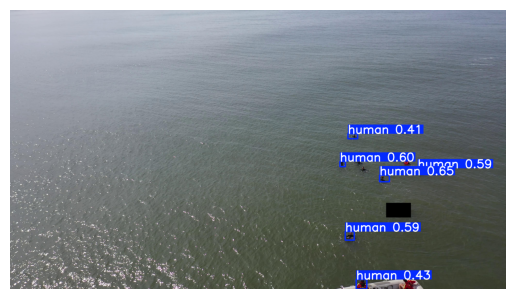

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 230 layers, 2,149,744 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/test... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:01<00:00, 157.36it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


                   all        250       1350      0.774      0.619       0.66      0.267


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.1ms preprocess, 3.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7faae0386390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

model.val(
    data=data_file,
    split="test"
)